# Proyek Klasifikasi Gambar: Shoe vs Sandal vs Boot
- **Nama:** Azhar Zuhro
- **Email:** azharzuhro74@gmail.com
- **ID Dicoding:** azharzuhro_IV41

## Import Semua Packages/Library yang Digunakan

In [ ]:
!pip install split-folders
!pip install tensorflowjs

# Library yang sering digunakan
import zipfile  # Untuk ekstraksi file zip
import os
import pathlib
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import splitfolders
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Libraries untuk pemrosesan data gambar
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TFSMLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from google.colab import files

## Data Preparation

In [ ]:
local_zip = '/content/Shoe vs Sandal vs Boot Dataset.zip' # Path ke file zip dataset
zip_ref = zipfile.ZipFile(local_zip, 'r') # Membuka file zip
zip_ref.extractall('/tmp') # Mengekstrak semua file ke direktori /tmp
zip_ref.close() # Menutup file zip setelah diekstrak

### Data Loading

In [ ]:
base_dir = '/tmp/Shoe vs Sandal vs Boot Dataset' # Direktori dataset yang telah diekstrak
shutil.rmtree('/tmp/Shoe vs Sandal vs Boot Dataset/rps-cv-images',ignore_errors=True) # Menghapus folder yang tidak diperlukan
splitfolders.ratio(base_dir, output=base_dir, ratio=(.8,.2))
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Copying files: 15000 files [00:04, 3630.46 files/s]


In [ ]:
os.listdir(train_dir) # Menampilkan daftar file di direktori training

['Sandal', 'Boot', 'Shoe']

In [ ]:
os.listdir(validation_dir) # Menampilkan daftar file di direktori validasi

['Sandal', 'Boot', 'Shoe']

### Data Preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,  # Menormalisasi nilai pixel gambar
                    rotation_range=20,  # Rotasi gambar secara acak
                    horizontal_flip=True,  # Membalik gambar secara horizontal secara acak
                    shear_range = 0.2,  # Menyisir gambar untuk augmentasi
                    fill_mode = 'nearest',  # Mengisi pixel yang hilang akibat transformasi
                    validation_split=0.2)  # Membagi 20% data untuk validasi

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.2
                    )

#### Split Dataset

In [ ]:
train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150), # Mengubah ukuran gambar menjadi 150x150
        batch_size=32,
        class_mode='categorical',
        classes=['Sandal', 'Shoe', 'Boot'],
        subset='training',

)

Found 12000 images belonging to 3 classes.


In [ ]:
valid_generator = test_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        classes=['Sandal', 'Shoe', 'Boot'],
        subset='validation',

)

Found 3000 images belonging to 3 classes.


## Modelling

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,530,691 (51.62 MB)

 Trainable params: 13,530,691 (51.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.95 and logs.get('val_accuracy') >= 0.95:
            print("\nAkurasi dan validasi akurasi telah mencapai >= 95%!")
            self.model.stop_training = True

callbacks = myCallback()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = 32,
    epochs = 50,
    validation_data = valid_generator,
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 - 176s - 6s/step - accuracy: 0.4492 - loss: 1.0448 - val_accuracy: 0.6657 - val_loss: 0.7725
Epoch 2/50
32/32 - 143s - 4s/step - accuracy: 0.6855 - loss: 0.7444 - val_accuracy: 0.7753 - val_loss: 0.5376
Epoch 3/50
32/32 - 144s - 4s/step - accuracy: 0.7451 - loss: 0.5934 - val_accuracy: 0.7813 - val_loss: 0.5239
Epoch 4/50
32/32 - 139s - 4s/step - accuracy: 0.7705 - loss: 0.5621 - val_accuracy: 0.8280 - val_loss: 0.4260
Epoch 5/50
32/32 - 163s - 5s/step - accuracy: 0.8389 - loss: 0.4308 - val_accuracy: 0.9147 - val_loss: 0.2642
Epoch 6/50
32/32 - 140s - 4s/step - accuracy: 0.8652 - loss: 0.3550 - val_accuracy: 0.8977 - val_loss: 0.2715
Epoch 7/50
32/32 - 144s - 5s/step - accuracy: 0.8350 - loss: 0.3905 - val_accuracy: 0.9070 - val_loss: 0.2531
Epoch 8/50
32/32 - 140s - 4s/step - accuracy: 0.8789 - loss: 0.3184 - val_accuracy: 0.9117 - val_loss: 0.2500
Epoch 9/50
32/32 - 141s - 4s/step - accuracy: 0.8740 - loss: 0.3435 - val_accuracy: 0.9203 - val_loss: 0.2065
Epoch 10/50
32/32 - 1

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 - 118s - 4s/step - accuracy: 0.9171 - loss: 0.2373 - val_accuracy: 0.9320 - val_loss: 0.1949
Epoch 13/50
32/32 - 142s - 4s/step - accuracy: 0.9072 - loss: 0.2629 - val_accuracy: 0.9053 - val_loss: 0.2583
Epoch 14/50
32/32 - 142s - 4s/step - accuracy: 0.9160 - loss: 0.2337 - val_accuracy: 0.9177 - val_loss: 0.2684
Epoch 15/50
32/32 - 148s - 5s/step - accuracy: 0.9111 - loss: 0.2195 - val_accuracy: 0.9437 - val_loss: 0.1534
Epoch 16/50
32/32 - 142s - 4s/step - accuracy: 0.9248 - loss: 0.2137 - val_accuracy: 0.9320 - val_loss: 0.1930
Epoch 17/50
32/32 - 162s - 5s/step - accuracy: 0.9316 - loss: 0.1824 - val_accuracy: 0.9403 - val_loss: 0.1716
Epoch 18/50
32/32 - 142s - 4s/step - accuracy: 0.9316 - loss: 0.2016 - val_accuracy: 0.9310 - val_loss: 0.1802
Epoch 19/50
32/32 - 147s - 5s/step - accuracy: 0.9404 - loss: 0.1837 - val_accuracy: 0.9433 - val_loss: 0.1634
Epoch 20/50
32/32 - 143s - 4s/step - accuracy: 0.9404 - loss: 0.1775 - val_accuracy: 0.9410 - val_loss: 0.1816
Epoch 21/50
3

## Evaluasi dan Visualisasi

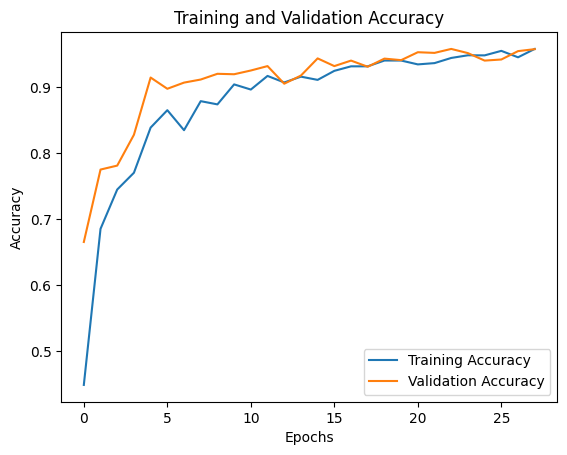

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy') # Plot akurasi training
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Plot akurasi validasi
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

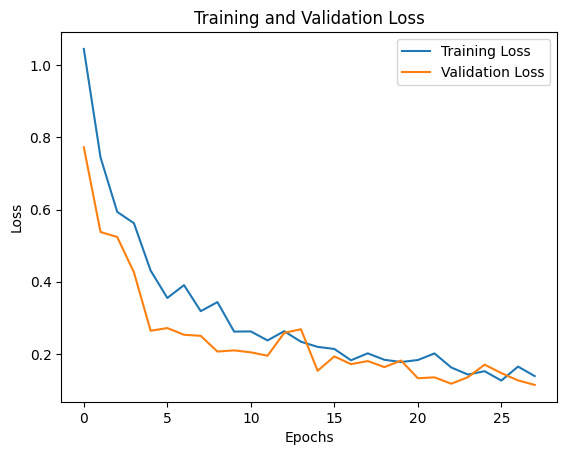

In [ ]:
plt.plot(history.history['loss'], label='Training Loss') # Plot loss training
plt.plot(history.history['val_loss'], label='Validation Loss') # Plot loss validasi
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Konversi Model

In [25]:
# Mengonversi model ke format saved model
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [26]:
# Mengonversi model ke format TFlite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

12864

In [29]:
# Mengonversi model ke format TFJS
tfjs.converters.save_keras_model(model, 'model_tfjs')

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference

Saving boot (10).jpg to boot (10).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
boot (10).jpg
Boot


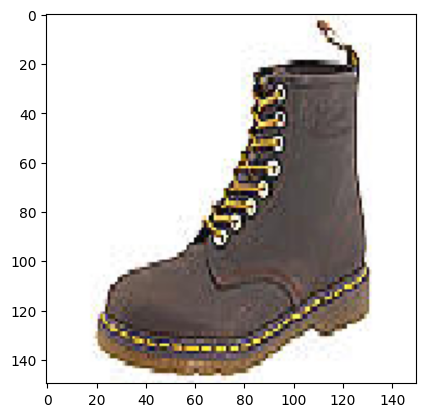

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(150,150)) # Membaca gambar dan mengubah ukurannya

  imgplot = plt.imshow(img) # Menampilkan gambar
  x = image.img_to_array(img) # Mengonversi gambar menjadi array
  x = np.expand_dims(x, axis=0) # Menambah dimensi untuk batch
  images = np.vstack([x]) # Menyusun gambar dalam satu batch

classes = model.predict(images, batch_size=10)
print(fn)
if classes[0][0]==1: # Menentukan kelas berdasarkan prediksi
    print('Sandal')
elif classes[0][1]==1:
    print('Shoe')
else:
    print('Boot')